# Overview

This project is an object detection and localization using Object Detection API with TensorFlow 2 where we used a dataset of three classes: Rock, Paper, and Scissor. We annotated and labeled the images to prepare for training, then used two different pre-trained models to compare performances. Models used are: SSD **MobileNet_v2_320x320** and **efficientdet_d0_coco17_tpu_32**, both models were trained for 2000 epochs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Steps:


1.   ### Data preprocessing (explained in this notebook)
2.   ### Training
3.   ### Evaluation  





# Data preprocessing

# import our dataset and pre-trained models

We get our dataset  of [rock-paper-scissors](https://github.com/DrGFreeman/rps-cv-data-science) first. Then we obtain our models from Tensorflow [repo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

### construct our workspace structure

Setting our directory tree to organize our work


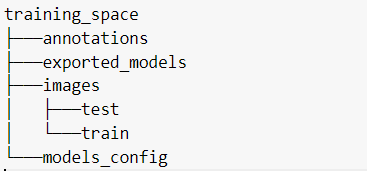

# Annotating our data
We start by installing the [LabelImg](https://github.com/tzutalin/labelImg)  to start annotating our images using pip:


```
!pip install labelImg

```
Then we specify the images directory and start annotating, the annotation including the label and coordinates will be stored in xml file with the same name of the image.
The labelImg should look something like this when opened:


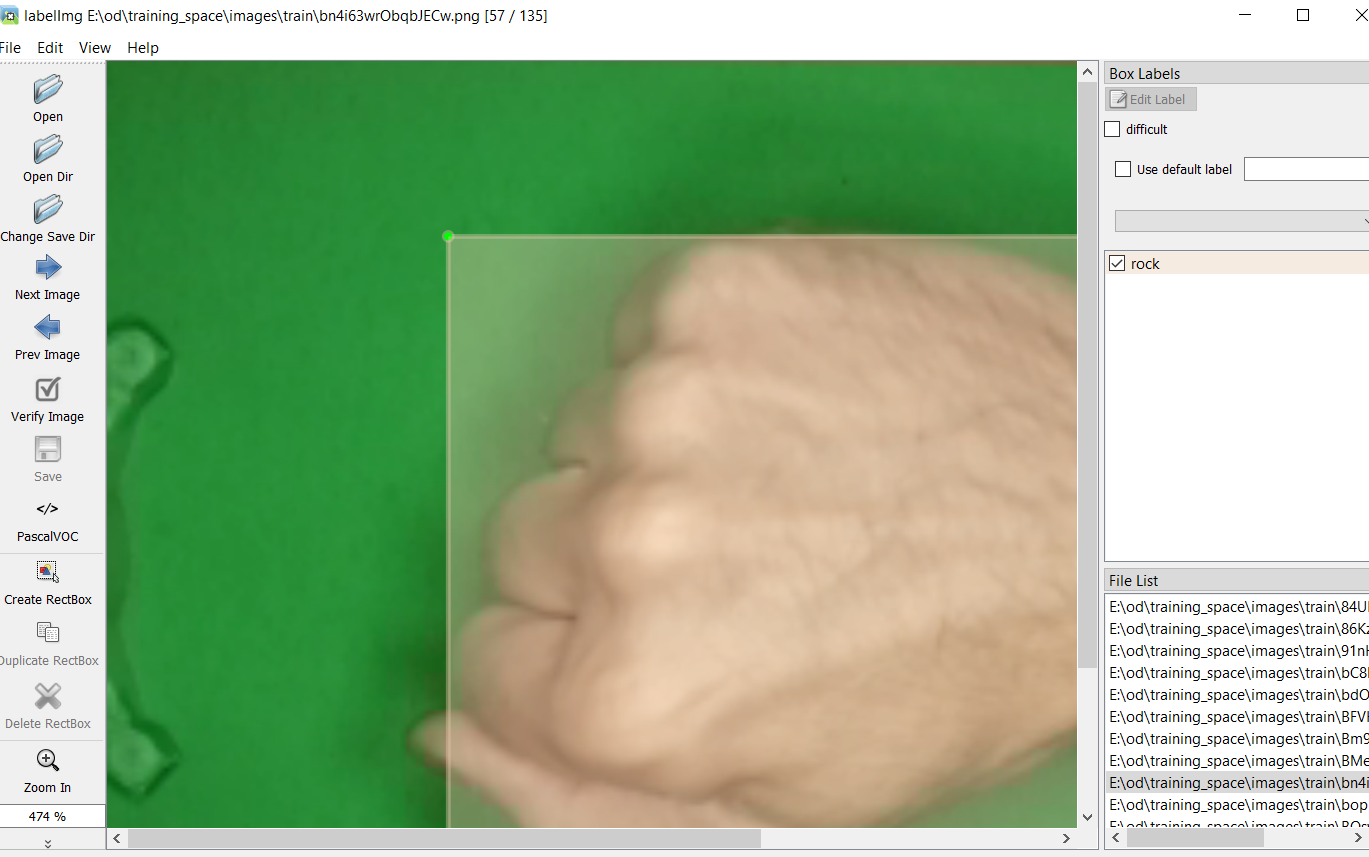

# create label map

We need to create a label map containing the classes names with their ID, it will be needed in making tfRecords and in our model  configuration file
```
item {
    id: 1
    name: 'rock'
}

item {
    id: 2
    name: 'paper'
}

item {
    id: 3
    name: 'scissor'
}

```



# Splitting data into train-test sets

Using the script ```partition_dataset.py``` in our main folder **training_space** we can specify our image directory, the train-test split ratio and also splitting the corresponding xml files to each image



In [ ]:
%cd /content/drive/MyDrive/od/training_space
!python partition_dataset.py -i imge -r .1 -x

/content/drive/MyDrive/od/training_space
Done partitioning!
/content/drive/MyDrive/od/training_space/partition_dataset.py:35: DeprecationWarning: Flags not at the start of the expression '([a-zA-Z0-9\\s_\\\\.\\-\\' (truncated) but at position 27
  if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(?i)(.jpg|.jpeg|.png)$', f)]


Tensorflow Object Detection API uses Protobufs to configure model and training parameters. Before the framework can be used, the Protobuf libraries must be downloaded and compiled.

In [ ]:
%cd /content/drive/MyDrive/od/models/research/
!protoc -I=./ --python_out=./ ./object_detection/protos/*.proto
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

import sys
sys.path.append('/content/models/research/object_detection') # ~/tensorflow/models/research/object_detection


/content/drive/MyDrive/od/models/research


# Generating TF Records

Using also the script ```generate_tfrecord.py``` in our main folder **training_space** we can pass out the directory of our images, xml, labels, and output for both train and test folders 

In [ ]:
%cd /content/drive/MyDrive/od
!python generate_tfrecord.py -x images/test -l /content/drive/MyDrive/od/training_space/annotations/label_map.pbtxt -o /content/drive/MyDrive/od/training_space/annotations/test.record
!python generate_tfrecord.py -x images/train -l /content/drive/MyDrive/od/training_space/annotations/label_map.pbtxt -o /content/drive/MyDrive/od/training_space/annotations/train.record


/content/drive/MyDrive/od
Successfully created the TFRecord file: /content/drive/MyDrive/od/training_space/annotations/test.record
Successfully created the TFRecord file: /content/drive/MyDrive/od/training_space/annotations/train.record


Now our data is ready for training !

# **Training** 

In order to have a smooth training for our data, we have to install all related dependencies for our training process.

We will use **%%capture** below which is a simple way to suppress unwanted output.


### Installing dependencies


In [ ]:
# Installing dependencies
%%capture 

!pip install tensorflow-gpu
!pip install tf_slim
!pip install lvis
!pip install tensorflow_io
!pip install tf-models-official
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python
!pip install --upgrade numpy
# !pip install tf-nightly


### Cloning TensorFlow object detection 2.0 models from Github

In [ ]:
%%capture 

# !git clone https://github.com/tensorflow/models.git

In [ ]:
%cd /content/drive/MyDrive/od/models/research/

/content/drive/MyDrive/od/models/research


In TensorFlow 2.x, the pycocotools package is listed as a dependency of the Object Detection API. So we should get it installed when using the Object Detection API 

In [ ]:
%%capture
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI
!make

In [ ]:
!cp -r /content/drive/MyDrive/od/models/research/cocoapi/PythonAPI/pycocotools /content/drive/MyDrive/od/models/research/

In [ ]:
%cd /content/drive/MyDrive/od/models/research/

/content/drive/Othercomputers/work_od/od/models/research


Installing the object_detection package.

In [ ]:
%%capture
!cp object_detection/packages/tf2/setup.py .
!python -m pip install --use-feature=2020-resolver 


### Modifying our configuration file for the first model

We need to specify our learning rate, epochs, training path and other instructions in ```pipeline.config```  file for each model before the start of the actual training process 

When opening that file, there are many hyperparameters to manipulate and fine-tune for further improvements, but here we are focusing on the ones we need for our project.



Setting the number of classes (in our case we have 3)
```
 num_classes: 3 
 ```
Setting our batch_size (we used low number due to memory limit in Colab free resources)
 ```
batch_size: 8 
```

 
Setting the path to our desired model (SSD MobileNet_v2_320x320 OR efficientdet_d0_coco17_tpu_32) and specify the path to checkpoint of pre-trained model
```
fine_tune_checkpoint: "path_to_pre-trained-model/checkpoint/ckpt-0" 
```
setting the desired number of steps
```
num_steps: 2000
```

we will set this to "detection" instead of classification
```
fine_tune_checkpoint_type: "detection" 
```

the last two lines below will be set one time for train.record and one time for test.record
```
label_map_path: "annotations/label_map.pbtxt" # Path to label map file
input_path: "annotations/train.record" # Path to training TFRecord file
```


### Starting The Training 

After installing all necessary dependencies, we can now start our training

##### The first model: SSD MobileNet_v2_320x320

In [ ]:
#train mobilenet
%cd /content/drive/MyDrive/od/object_detection/
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/od/training_space/models_config/mobilenet --pipeline_config_path=/content/drive/MyDrive/od/training_space/models_config/mobilenet/pipeline.config --alsologtostderr


Exporting our trained model

In [ ]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/drive/MyDrive/od/training_space/models_config/mobilenet/pipeline.config --trained_checkpoint_dir /content/drive/MyDrive/od/training_space/models_config/mobilenet --output_directory /content/drive/MyDrive/od/training_space/exported_models/exported_mobilenet


##### The Second model: Efficientdet_d0_coco17_tpu_32

In [ ]:
#train efficientdet_d0_coco17_tpu_32
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/od/training_space/models_config/efficientdet_d0_coco17_tpu_32 --pipeline_config_path=/content/drive/MyDrive/od/training_space/models_config/efficientdet_d0_coco17_tpu_32/pipeline.config


2021-12-19 23:50:10.268738: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1219 23:50:10.272590 140272885966720 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I1219 23:50:10.995187 140272885966720 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1219 23:50:10.995453 140272885966720 config_util.py:552] Maybe overwriting use_bfloat16: False
I1219 23:50:11.006850 140272885966720 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I1219 23:50:11.006979 140272885966720 ssd_efficientnet_bifpn_feature_extractor.py:144] 

In [ ]:
#export efficientdet_d0_coco17_tpu_32 
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/drive/MyDrive/od/training_space/models_config/efficientdet_d0_coco17_tpu_32/pipeline.config --trained_checkpoint_dir /content/drive/MyDrive/od/training_space/models_config/efficientdet_d0_coco17_tpu_32 --output_directory /content/drive/MyDrive/od/training_space/exported_models/exported_efficientdet_d0_coco17_tpu_32


2022-01-03 05:34:26.208480: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0103 05:34:26.254548 140308114024320 ssd_efficientnet_bifpn_feature_extractor.py:143] EfficientDet EfficientNet backbone version: efficientnet-b0
I0103 05:34:26.254778 140308114024320 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 64
I0103 05:34:26.254869 140308114024320 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet BiFPN num iterations: 3
I0103 05:34:26.258966 140308114024320 efficientnet_model.py:147] round_filter input=32 output=32
I0103 05:34:26.316798 140308114024320 efficientnet_model.py:147] round_filter input=32 output=32
I0103 05:34:26.316976 140308114024320 efficientnet_model.py:147] round_filter input=16 output=16
I0103 05:34:26.381664 140308114024320 efficientnet_model.py:147] round_filter input=16 output=16
I0103 05:34:26.381856 140308114024320 efficientnet_model.